# Is it a banger?

In [1]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_pickle("../data/processed_dataset.pkl")


In [3]:
def plot_waveforms(audio, log_specgram):
    # audio is np.array holding sample values, log_specgram is 2-dim np.array
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    librosa.display.waveplot(audio, sr=22050)
    plt.subplot(1, 2, 2)
    librosa.display.specshow(log_specgram, x_axis='time',y_axis='log')
    plt.colorbar(format='%+2.0f dB')

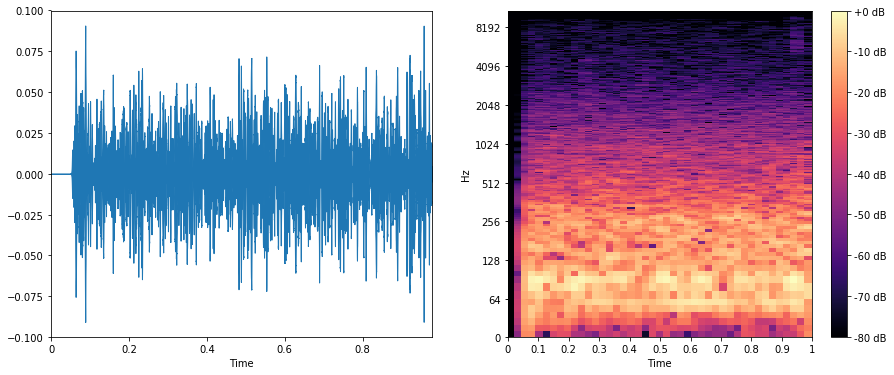

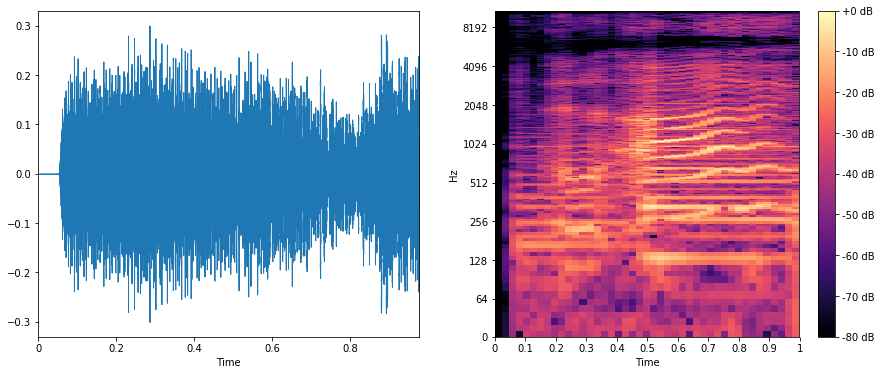

In [4]:
plot_waveforms(df.iloc[1]["audio"], df.iloc[1]["log_specgram"])
plot_waveforms(df.iloc[5]["audio"], df.iloc[4]["log_specgram"])

In [5]:
df.iloc[1].name, df.iloc[5].name

('The Lumineers - Angela004.wav', 'Mumford & Sons - I Will Wait014.wav')

`log_specgram` has shape `(1024, 43)`. need to work out why. Probably related to number of samples (REVISE) `109750`

In [6]:
log_specgram_shape = df.iloc[0]["log_specgram"].shape
print(log_specgram_shape)

(1025, 43)


## Establish baseline

In [7]:
print ("This is the error rate if we always guess max{# banger, #not_a_banger}: %.2f" % 
(min(df[df["label"] == "banger"].index.size, df[df["label"] == "not_a_banger"].index.size) / (float)(df.index.size)) )

This is the error rate if we always guess max{# banger, #not_a_banger}: 0.16


## Form the training and testing data sets¶

In [8]:
train_frac = 0.8

def split_train_test(df, train_frac=0.8):
    include = np.random.rand(*df.index.shape)
    is_train = include < train_frac
    train_data = df[is_train]
    test_data = df[~is_train]
    return train_data, test_data
                
train_data, test_data = split_train_test(df, train_frac)

In [9]:
print(train_data.shape)
print(test_data.shape)

(643, 4)
(163, 4)


In [10]:
def export_numpy_features(df):
    x = np.vstack(df["log_specgram"]).reshape(df.shape[0], *log_specgram_shape, 1).astype(np.float32)
    y = np.vstack(df["label_one_hot"])
    return x, y
    
train_x, train_y = export_numpy_features(train_data)
test_x, test_y = export_numpy_features(test_data)

# for index, row in df.iterrows() :
#      print(row['audio'].shape, row['log_specgram'].shape, index)

In [11]:
import tensorflow as tf
tf.set_random_seed(1234)

In [55]:
# convolution params
CONV_STRIDE_LENGTH = 1
CONV_WINDOW_LENGTH = 5
MAX_POOL_STRIDE_LENGTH = 2

# features
CONV_1_NUM_FEATURES = 32
CONV_2_NUM_FEATURES = 16
DENSE_NUM_FEATURES = 256

# training
NUM_LABELS = df.label.unique().size
BATCH_SIZE = 50
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4

In [56]:
# This node is where we feed a batch of the training data and labels at each training step
x = tf.placeholder(tf.float32,shape=(None, *log_specgram_shape, 1))
y_ = tf.placeholder(tf.float32, shape=(None, len(df.label.unique())))

In [57]:
# Weight initialisation functions
 
# small noise for symmetry breaking and non-zero gradients
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# ReLU neurons - initialise with small positive bias to stop 'dead' neurons
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [58]:
# Convolutions + max pooling

# format: strides = [1, stride, stride, 1]
# W is filter
# input tensor of shape [batch, in_height, in_width, in_channels] 
# and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
def conv2d(x, W):  
    return tf.nn.conv2d(x, W, strides=[1, CONV_STRIDE_LENGTH, CONV_STRIDE_LENGTH, 1], padding='SAME')

# ksize is filter size
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1],
                        strides=[1, MAX_POOL_STRIDE_LENGTH, MAX_POOL_STRIDE_LENGTH, 1], padding='SAME')



### First Convolutional Layer
We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of `[5, 5, 1, 32]`. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [59]:
W_conv1 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, 1, CONV_1_NUM_FEATURES])
b_conv1 = bias_variable([CONV_1_NUM_FEATURES])

In [60]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [61]:
h_pool1.shape # check shape

TensorShape([Dimension(None), Dimension(513), Dimension(22), Dimension(32)])

### Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 16 features for each 5x5 patch.

In [62]:
W_conv2 = weight_variable([CONV_WINDOW_LENGTH, CONV_WINDOW_LENGTH, CONV_1_NUM_FEATURES, CONV_2_NUM_FEATURES])
b_conv2 = bias_variable([CONV_2_NUM_FEATURES])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 2x2 maxpool gives image dimensions np.ceil(np.array(log_specgram_shape)/2).astype(int)

In [63]:
h_pool2.shape

TensorShape([Dimension(None), Dimension(257), Dimension(11), Dimension(16)])

### Densely Connected Layer

Now that the image size has been reduced to `$SHAPE`, we add a fully-connected layer with 256 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [64]:
def scale_shape_maxpool2x2(shape_tuple):
    return np.ceil(np.array(shape_tuple)/2).astype(int)

log_specgram_shape_reduced = scale_shape_maxpool2x2(scale_shape_maxpool2x2(log_specgram_shape))

W_fc1 = weight_variable([np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES, DENSE_NUM_FEATURES])
b_fc1 = bias_variable([DENSE_NUM_FEATURES])

h_pool2_flat = tf.reshape(h_pool2, [-1, np.prod(log_specgram_shape_reduced) * CONV_2_NUM_FEATURES])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [65]:
h_pool2_flat.shape

TensorShape([Dimension(None), Dimension(45232)])

### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a `placeholder` for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's `tf.nn.dropout` op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [66]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

Finally, we add a layer, just like for the one layer softmax regression.

In [67]:
W_fc2 = weight_variable([DENSE_NUM_FEATURES, NUM_LABELS])
b_fc2 = bias_variable([NUM_LABELS])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

### Batching function

In [68]:
def return_batch(df, batch_size=10):
    batch_df = df.sample(batch_size)
    x = np.vstack(batch_df["log_specgram"]).reshape(batch_df.shape[0], *log_specgram_shape, 1).astype(np.float32)
    y = np.vstack(batch_df["label_one_hot"])
    return x, y

### Train and Evaluate the Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

The differences are that:

- We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.
- We will include the additional parameter `keep_prob` in `feed_dict` to control the dropout rate.
- We will add logging to every 100th iteration in the training process.

We will also use `tf.Session` rather than `tf.InteractiveSession`. This better separates the process of creating the graph (model specification) and the process of evaluating the graph (model fitting). It generally makes for cleaner code. The `tf.Session` is created within a with block so that it is automatically destroyed once the block is exited.

Feel free to run this code. Be aware that it does 200 training iterations and may take a while (possibly up to half an hour), depending on your processor.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

with sess.as_default():
    for i in range(NUM_EPOCHS):
        batch = return_batch(train_data, BATCH_SIZE)
        if i % 1 == 0:
            train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %.2f' % (i, train_accuracy))

        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    
    test_batch = return_batch(test_data, test_data.shape[0])
    test_accuracy = accuracy.eval(feed_dict={
          x: test_batch[0], y_: test_batch[1], keep_prob: 1.0})
    print('test accuracy %.2f' % test_accuracy)

step 0, training accuracy 0.58
step 1, training accuracy 0.84
step 2, training accuracy 0.74
step 3, training accuracy 0.88
step 4, training accuracy 0.84
step 5, training accuracy 0.80
step 6, training accuracy 0.82
step 7, training accuracy 0.80
step 8, training accuracy 0.40
step 9, training accuracy 0.70
step 10, training accuracy 0.82
step 11, training accuracy 0.84
step 12, training accuracy 0.84
step 13, training accuracy 0.88
step 14, training accuracy 0.88
step 15, training accuracy 0.80
step 16, training accuracy 0.92
step 17, training accuracy 0.86
step 18, training accuracy 0.86
step 19, training accuracy 0.80
step 20, training accuracy 0.82
step 21, training accuracy 0.92
step 22, training accuracy 0.84
step 23, training accuracy 0.88
step 24, training accuracy 0.78
step 25, training accuracy 0.86
step 26, training accuracy 0.88
step 27, training accuracy 0.90
step 28, training accuracy 0.86
step 29, training accuracy 0.80
step 30, training accuracy 0.82
step 31, training 